In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
import warnings

print("Imoprted Complitely!")

2024-02-11 18:17:30.363773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 18:17:30.363906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 18:17:30.485741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Imoprted Complitely!


/tmp/ipykernel_26/95286717.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


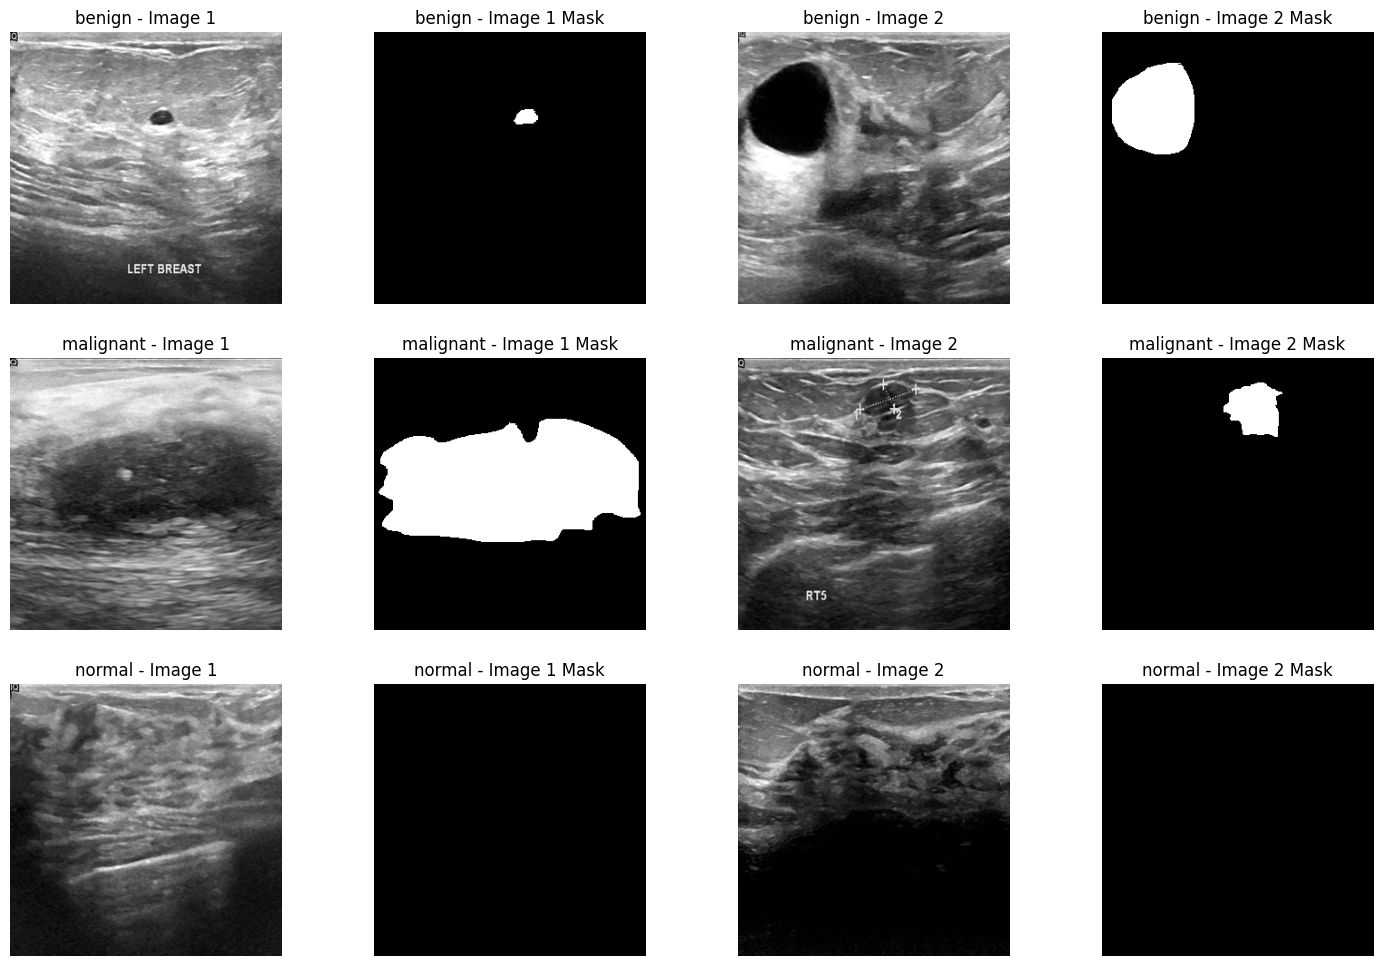

In [2]:
labels = ['benign', 'malignant', 'normal']
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

fig, axs = plt.subplots(3, 4, figsize=(18, 12))

desired_width = 300
desired_height = 300

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)
    
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]
    
    image_files = sorted(image_files)
    
    for j in range(4):
        if j < len(image_files):
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.ANTIALIAS)
            
            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'
            
            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

In [3]:
working_dir = '/kaggle/working'

for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)
        
print("working output path cleared!")

working output path cleared!


In [4]:
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


/tmp/ipykernel_26/3487001929.py:64: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


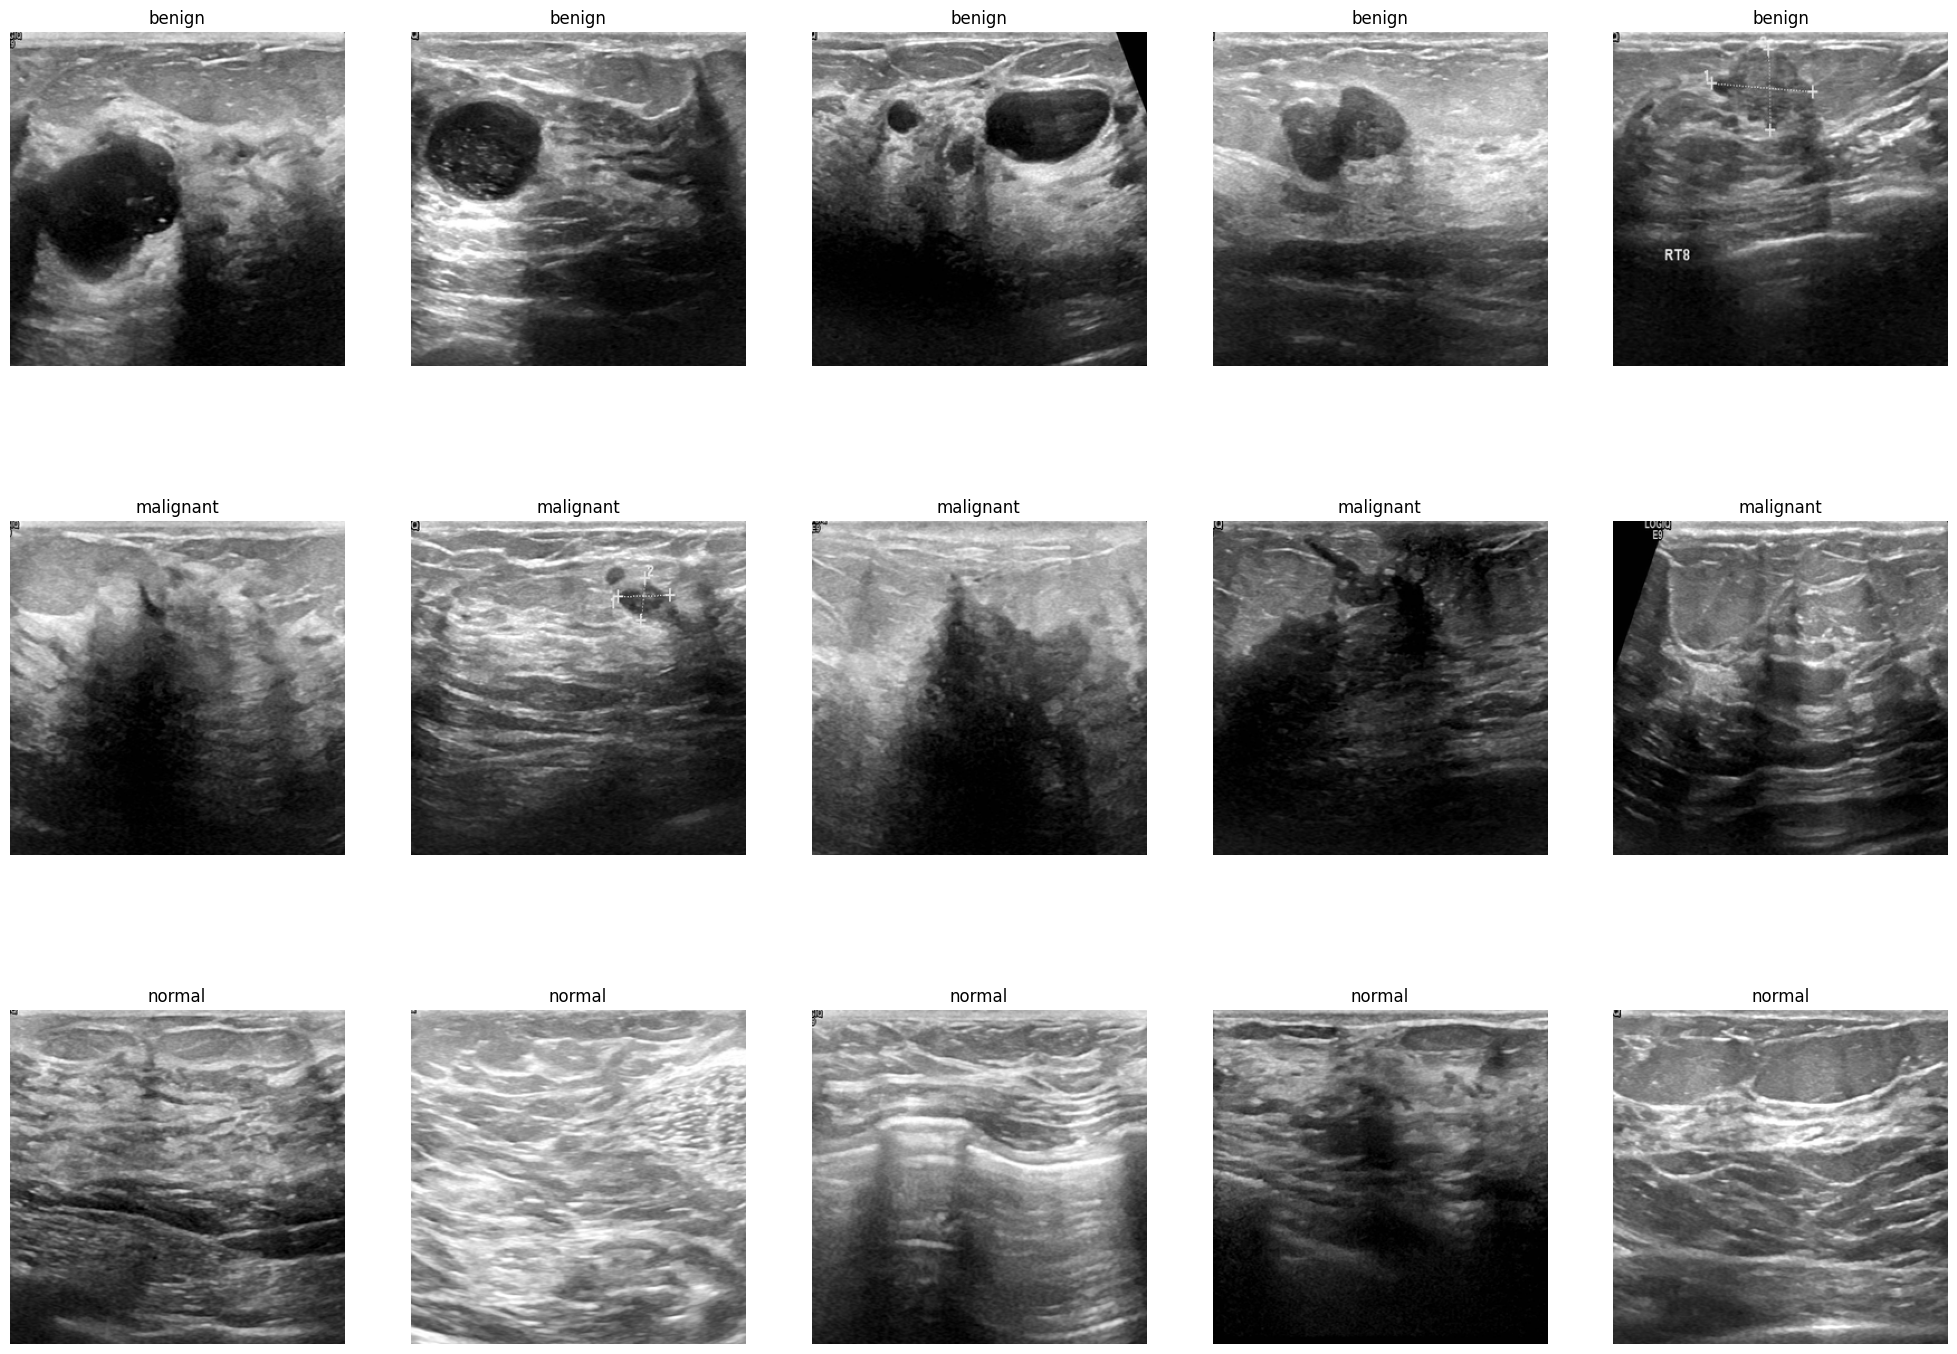

In [6]:
train_dir = '/kaggle/working/train'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Train {category}: {count}")

validation_dir = '/kaggle/working/validation'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Validation {category}: {count}")

test_dir = '/kaggle/working/test'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"test {category}: {count}")


train_dir = '/kaggle/working/train'

labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(train_dir, label) for label in labels]

fig, axs = plt.subplots(3, 5, figsize=(25, 18))

desired_width = 300
desired_height = 300

for i, label_dir in enumerate(label_dirs):
    images = [image for image in os.listdir(label_dir) if not image.endswith('_mask.png')][:5]

    for j, image_filename in enumerate(images):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)
        
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)
        
        axs[i, j].imshow(image)
        axs[i, j].set_title(labels[i])
        axs[i, j].axis('off')


data_dir='/kaggle/working/'

image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

In [7]:
batch_size = 8

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    consecutive_epochs_without_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'train':
                    train_losses.append(loss.item())
                else:
                    val_losses.append(loss.item())

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1


                val_losses.append(epoch_loss)

        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))
   
    model.load_state_dict(best_model_wts)
    
    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix 1:")
    print(cm)

    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 170MB/s]


Epoch 0/19
----------
train Loss: 0.8972 Acc: 0.5524
validation Loss: 0.6439 Acc: 0.7200

Epoch 1/19
----------
train Loss: 0.6041 Acc: 0.7780
validation Loss: 0.5226 Acc: 0.8000

Epoch 2/19
----------
train Loss: 0.4909 Acc: 0.8242
validation Loss: 0.4808 Acc: 0.7800

Epoch 3/19
----------
train Loss: 0.3498 Acc: 0.8792
validation Loss: 0.4058 Acc: 0.8600

Epoch 4/19
----------
train Loss: 0.3431 Acc: 0.8845
validation Loss: 0.4058 Acc: 0.8500

Epoch 5/19
----------
train Loss: 0.2720 Acc: 0.9076
validation Loss: 0.4334 Acc: 0.8600
Early stopping after 5 epochs
Training complete in 0m 48s
Best val Loss: 0.4058
              precision    recall  f1-score   support

      benign       0.83      0.98      0.90        56
   malignant       0.95      0.67      0.78        27
      normal       0.87      0.76      0.81        17

    accuracy                           0.86       100
   macro avg       0.88      0.80      0.83       100
weighted avg       0.87      0.86      0.85       100



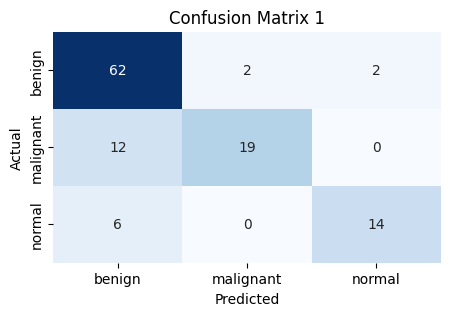

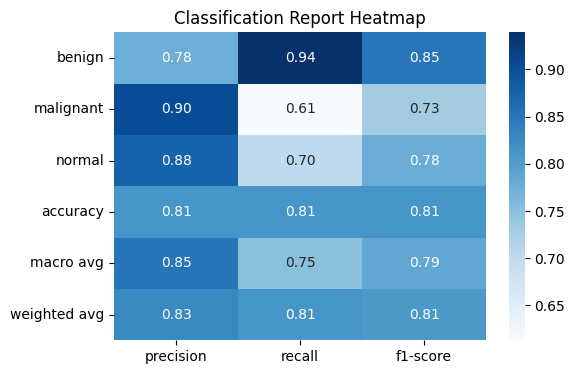

Simplified Classification Report:
             benign  malignant    normal  accuracy  macro avg  weighted avg
precision  0.775000   0.904762  0.875000  0.811966   0.851587      0.826475
recall     0.939394   0.612903  0.700000  0.811966   0.750766      0.811966
f1-score   0.849315   0.730769  0.777778  0.811966   0.785954      0.805677


In [8]:
# Load the pretrained model
DenseNet121 = models.densenet121(pretrained=True)

# Set requires_grad = True for all parameters
for param in DenseNet121.parameters():
    param.requires_grad = True

# Get the number of input features of the last layer
in_features = DenseNet121.classifier.in_features

# Replace the last layer with a new one with output features equal to the number of classes
DenseNet121.classifier = nn.Linear(in_features, len(class_names))

# Move the model to the device
DenseNet121_fineTuning = DenseNet121.to(device)

# Define the optimizer
optimizer = optim.Adam(DenseNet121_fineTuning.parameters(), lr=0.00005)

# Define the learning rate scheduler
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the loss function
Loss_Function = nn.CrossEntropyLoss()

# Train the model with early stopping
model_fineTuning1 = train_model_with_early_stopping(
    DenseNet121_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, 
    dataloaders, dataset_sizes, class_names, device,num_epochs=20, patience=2)

# Save the model
torch.save(model_fineTuning1, "/kaggle/working/DenseNet121_approach1.keras")

label_names = [str(class_names[i]) for i in range(len(class_names))]

y_true = []
y_pred = []

model_fineTuning1.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning1(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])

In [9]:
# Set the path to the Kaggle working directory
working_dir = '/kaggle/working'

# Delete all files and subdirectories in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Confirm that the directory is empty
print("Kaggle working directory has been cleared.")



warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

output_dir = '/kaggle/working/OverlayedImages'

labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

def overlay_and_save(image_path, mask_path, output_path):
    try:
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            if image.size != mask.size:
                image = image.resize(mask.size)

            overlayed = Image.blend(image, mask, alpha=0.5)

            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to /kaggle/working/OverlayedImages directory.")

Kaggle working directory has been cleared.
Overlayed images have been saved to /kaggle/working/OverlayedImages directory.


In [10]:
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
output_dir = '/kaggle/working/OverlayedImages'

input_counts = {}
output_counts = {}

for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")


File Counts Before Overlay-includes masks:
benign: 891 files
normal: 266 files
malignant: 421 files

File Counts After Overlay:
benign: 437 files
malignant: 210 files
normal: 133 files


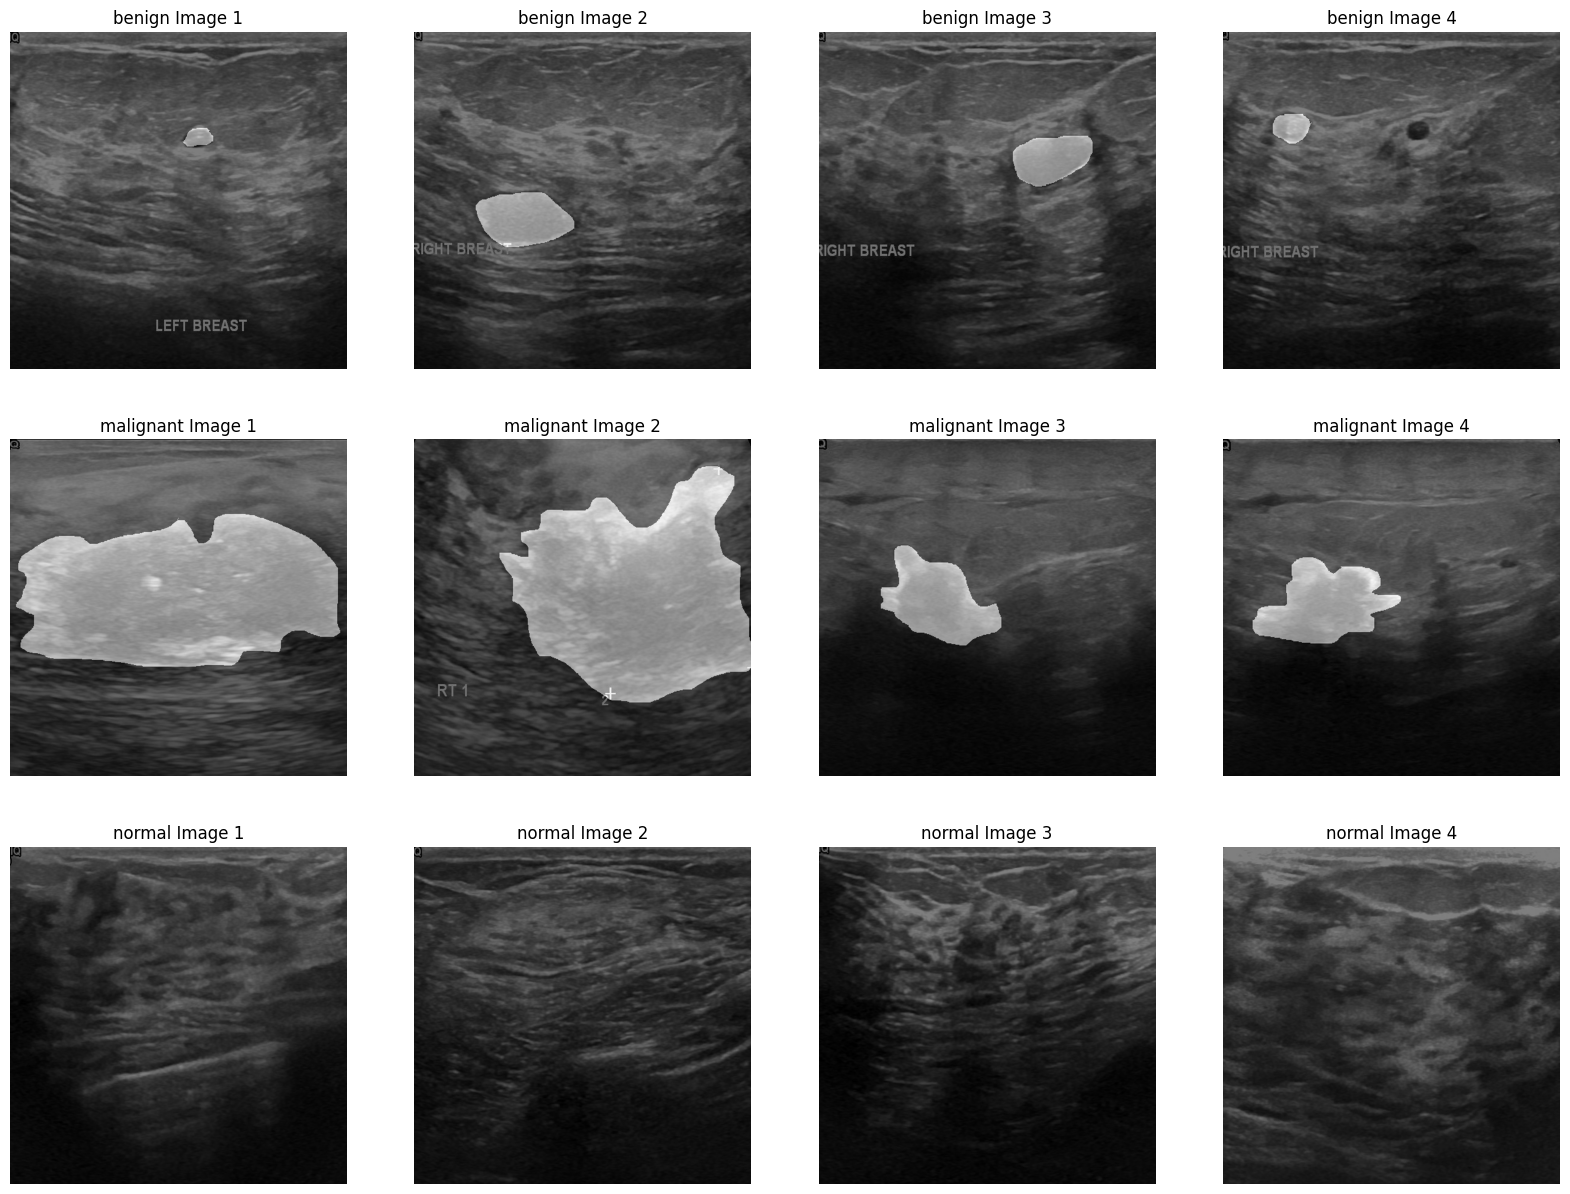

In [11]:
overlayed_dir = '/kaggle/working/OverlayedImages'

labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

fig, axs = plt.subplots(3, 4, figsize=(20, 15))

desired_width = 800
desired_height = 800

for i, label_dir in enumerate(label_dirs):
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))

    for j, image_filename in enumerate(images[:4]):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()


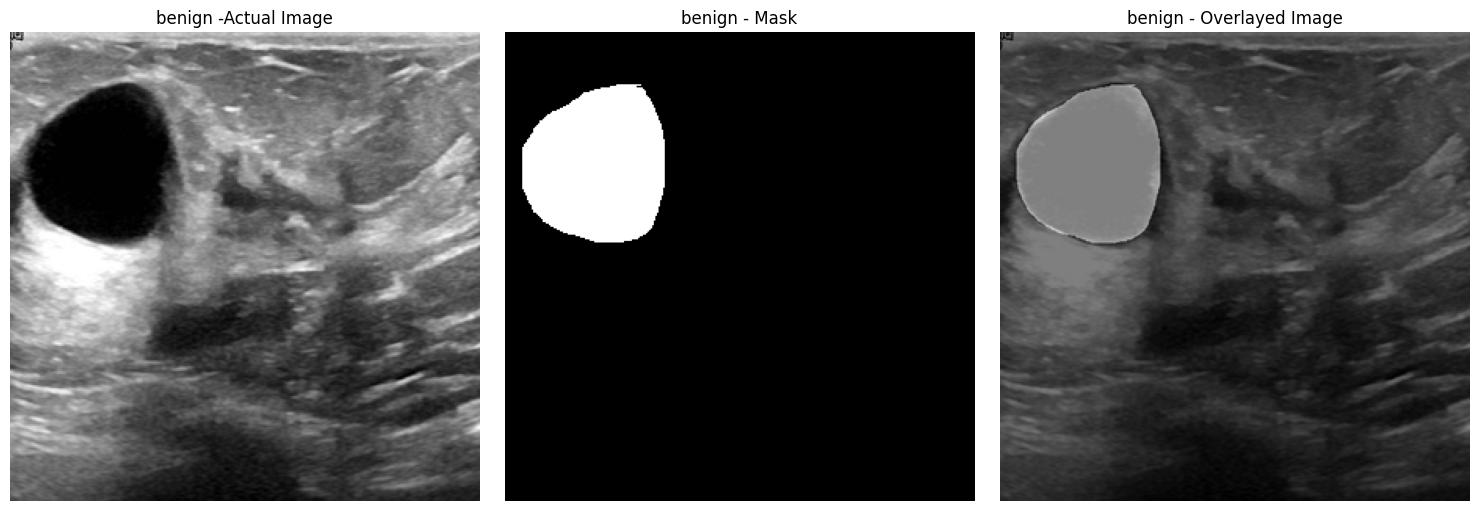

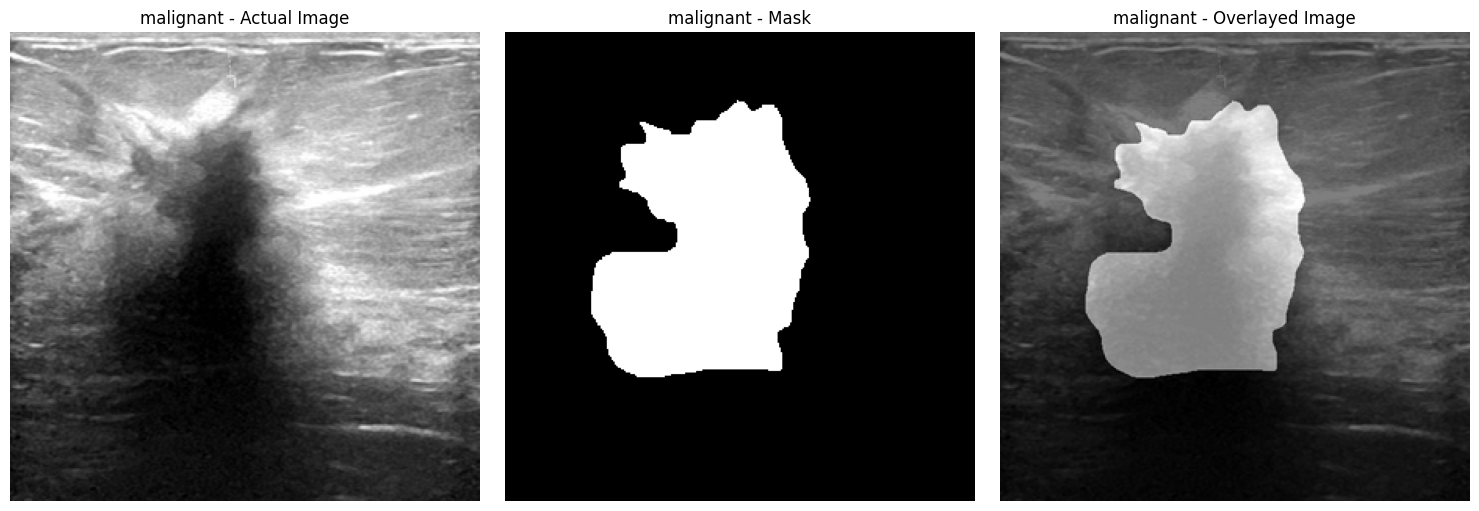

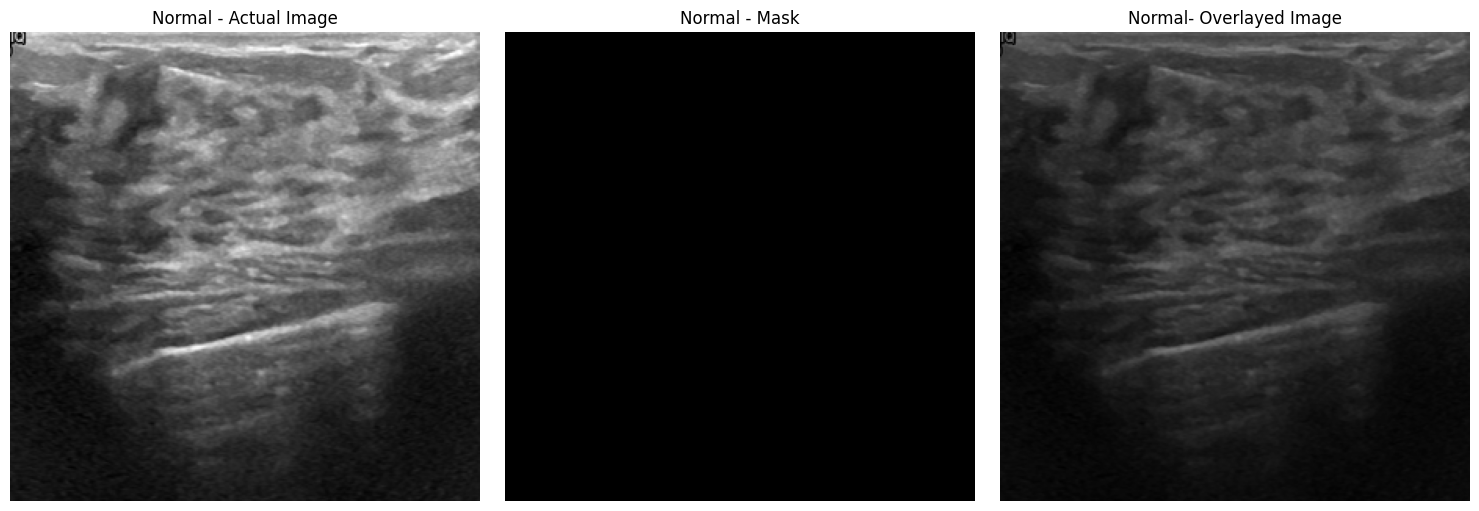

In [12]:
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/benign'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'benign (10).png'

actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('benign -Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('benign - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/malignant'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'malignant (103).png'

actual_image_path = os.path.join(input_dir, 'malignant', image_filename)
mask_image_path = os.path.join(input_dir, 'malignant', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('malignant - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('malignant - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('malignant - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/normal'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'normal (1).png'

actual_image_path = os.path.join(input_dir, 'normal', image_filename)
mask_image_path = os.path.join(input_dir, 'normal', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('Normal - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Normal - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Normal- Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [13]:
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/working/OverlayedImages'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)


In [14]:
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))


file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Train {category}: {count}")

validation_dir = '/kaggle/working/validation'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Validation {category}: {count}")


test_dir = '/kaggle/working/test'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"test {category}: {count}")

data_dir='/kaggle/working/'

image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}


Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


In [15]:
batch_size = 8

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

train_dir = '/kaggle/working/train'

subdirectories = ['benign', 'malignant', 'normal']


Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/19
----------
train Loss: 0.5679 Acc: 0.8082
validation Loss: 0.1503 Acc: 0.9800

Epoch 1/19
----------
train Loss: 0.2215 Acc: 0.9556
validation Loss: 0.1162 Acc: 0.9700

Epoch 2/19
----------
train Loss: 0.1407 Acc: 0.9556
validation Loss: 0.0828 Acc: 0.9700

Epoch 3/19
----------
train Loss: 0.1248 Acc: 0.9698
validation Loss: 0.0719 Acc: 0.9700

Epoch 4/19
----------
train Loss: 0.0670 Acc: 0.9840
validation Loss: 0.0679 Acc: 0.9700

Epoch 5/19
----------
train Loss: 0.0776 Acc: 0.9822
validation Loss: 0.0672 Acc: 0.9700

Epoch 6/19
----------
train Loss: 0.0725 Acc: 0.9805
validation Loss: 0.0899 Acc: 0.9700

Epoch 7/19
----------
train Loss: 0.0635 Acc: 0.9876
validation Loss: 0.1181 Acc: 0.9700
Early stopping after 7 epochs
Training complete in 1m 2s
Best val Loss: 0.0672
              precision    recall  f1-score   support

      benign       0.95      1.00      0.97        56
   malignant       1.00      0.89      0.94        27
      normal       1.00      1.00      

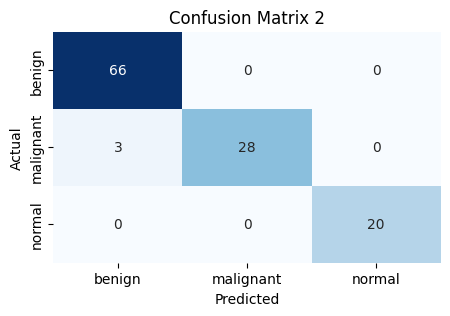

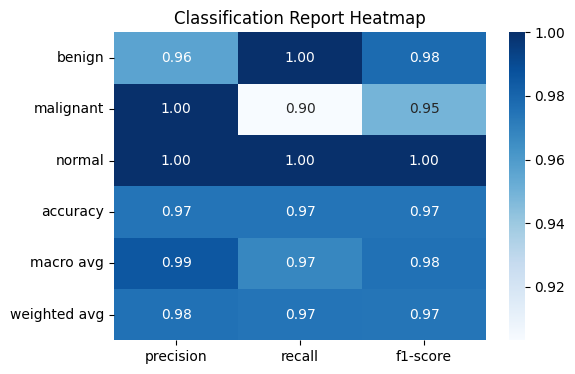

Simplified Classification Report:
             benign  malignant  normal  accuracy  macro avg  weighted avg
precision  0.956522   1.000000     1.0  0.974359   0.985507      0.975474
recall     1.000000   0.903226     1.0  0.974359   0.967742      0.974359
f1-score   0.977778   0.949153     1.0  0.974359   0.975643      0.973992


In [16]:
# Load the pretrained model
DenseNet121 = models.densenet121(pretrained=True)

# Set requires_grad = True for all parameters
for param in DenseNet121.parameters():
    param.requires_grad = True

# Get the number of input features of the last layer
in_features = DenseNet121.classifier.in_features

# Replace the last layer with a new one with output features equal to the number of classes
DenseNet121.classifier = nn.Linear(in_features, len(class_names))

# Move the model to the device
DenseNet121_fineTuning = DenseNet121.to(device)

# Define the optimizer
optimizer = optim.Adam(DenseNet121_fineTuning.parameters(), lr=0.00005)

# Define the learning rate scheduler
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the loss function
Loss_Function = nn.CrossEntropyLoss()

# Train the model with early stopping
model_fineTuning2 = train_model_with_early_stopping(
    DenseNet121_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, 
    dataloaders, dataset_sizes, class_names, device,num_epochs=20, patience=2)


label_names = [str(class_names[i]) for i in range(len(class_names))]

y_true = []
y_pred = []

model_fineTuning2.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning2(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 2')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])

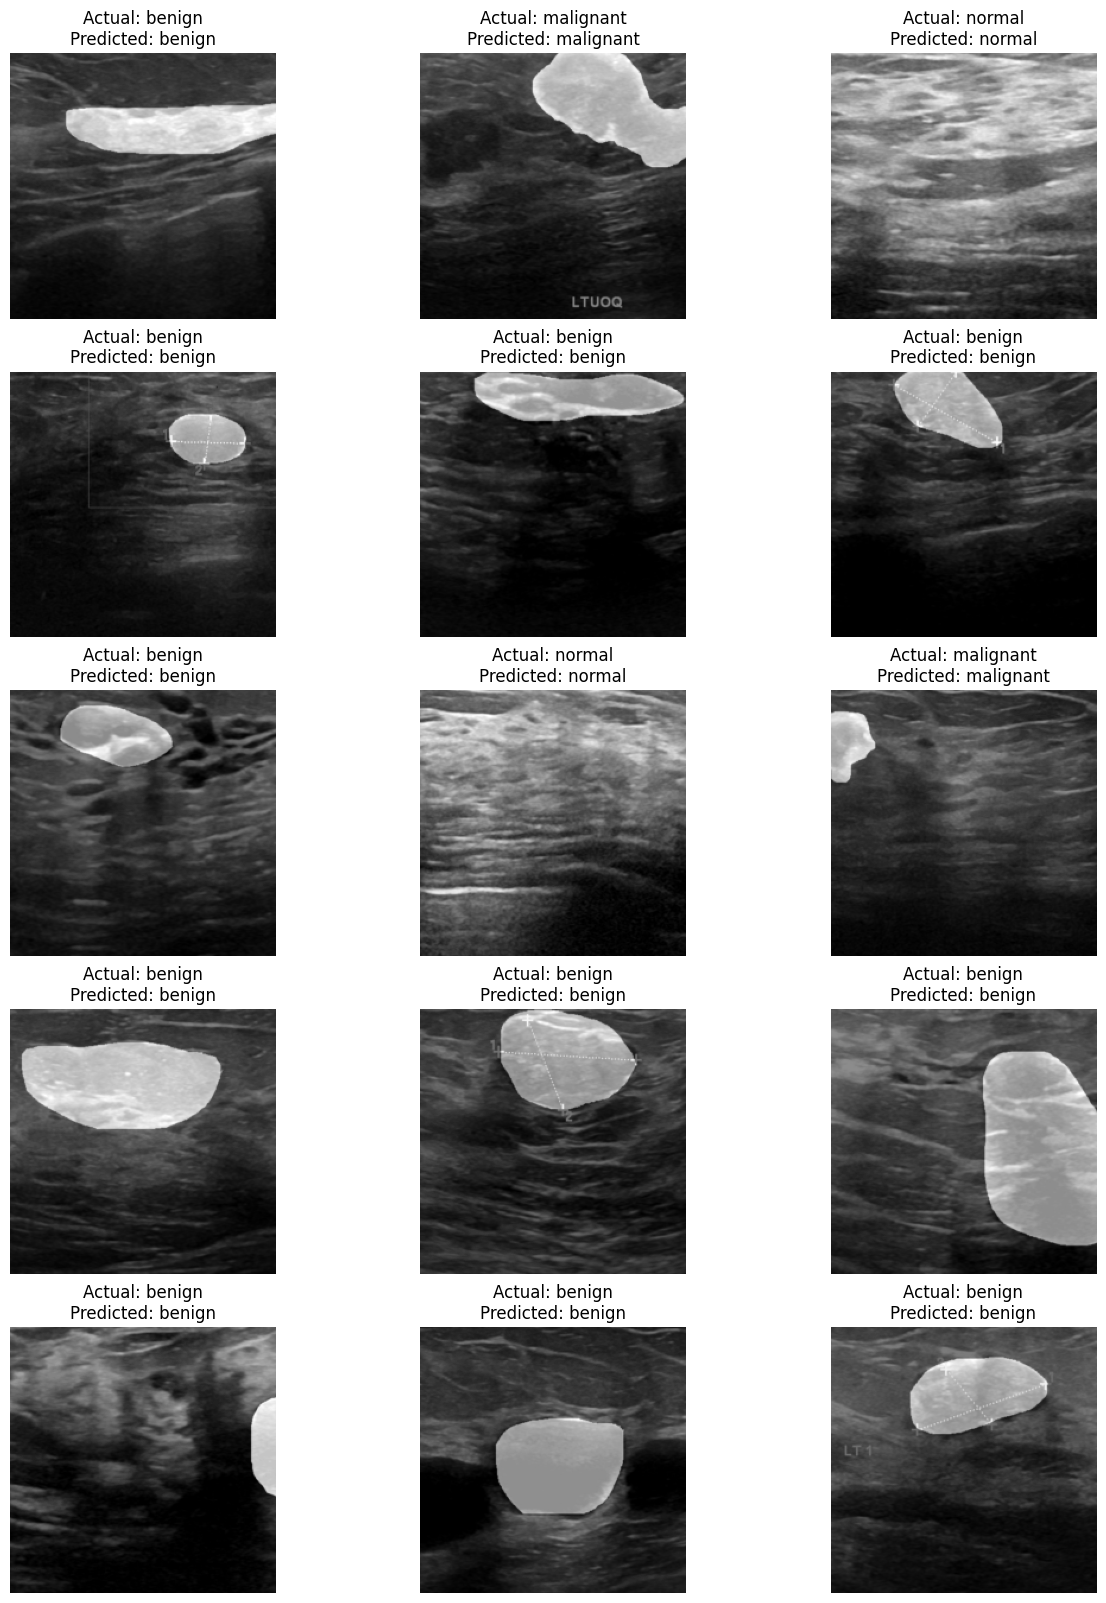

In [17]:
num_images_to_display = 15

test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

inputs, labels = next(iter(test_dataloader))

inputs = inputs.to(device)

grayscale_images = inputs.cpu().numpy().mean(axis=1)

with torch.no_grad():
    model_fineTuning2.eval()
    outputs = model_fineTuning2(inputs)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 20))
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')

plt.show()

(7, 7)


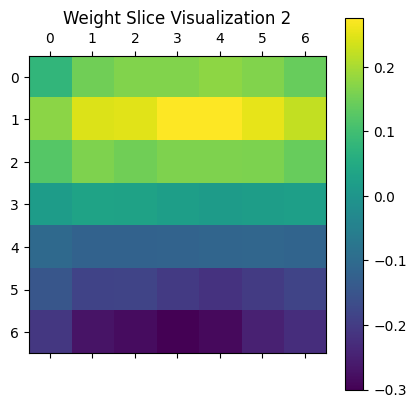

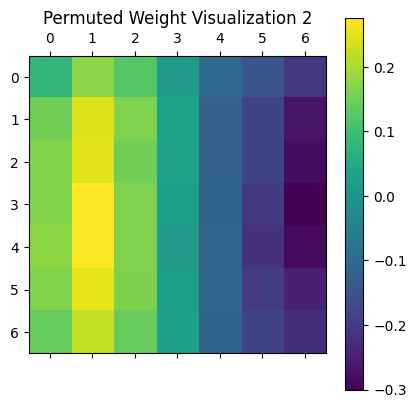

Slice Matrix 2=  [[ 0.07837545  0.14969291  0.16628219  0.16640596  0.17687029  0.1660369
   0.14119825]
 [ 0.17553431  0.24420324  0.25015312  0.27514255  0.2747536   0.25269386
   0.22222885]
 [ 0.12332848  0.16448268  0.14938097  0.16346626  0.16334268  0.16225952
   0.14091296]
 [ 0.01670336  0.03359997  0.02978669  0.02257366  0.01588196  0.01987167
   0.02468799]
 [-0.10452069 -0.12050429 -0.11950508 -0.11878116 -0.11322155 -0.11151059
  -0.11627892]
 [-0.14735088 -0.18643644 -0.18257093 -0.20302519 -0.21669042 -0.2018467
  -0.18280202]
 [-0.20717013 -0.27106062 -0.2814472  -0.30152303 -0.28696343 -0.24863224
  -0.2258449 ]]
permuted Matrix 2=  [[ 0.07837545  0.17553431  0.12332848  0.01670336 -0.10452069 -0.14735088
  -0.20717013]
 [ 0.14969291  0.24420324  0.16448268  0.03359997 -0.12050429 -0.18643644
  -0.27106062]
 [ 0.16628219  0.25015312  0.14938097  0.02978669 -0.11950508 -0.18257093
  -0.2814472 ]
 [ 0.16640596  0.27514255  0.16346626  0.02257366 -0.11878116 -0.20302519


In [18]:
conv = next(m for m in model_fineTuning2.modules() if isinstance(m, torch.nn.Conv2d))
weights = conv.weight

slice = weights[0,0,:,:]  

slice = slice.detach()

slice = slice.cpu()

slice_np = slice.numpy()  

print(slice_np.shape)

plt.matshow(slice_np)
plt.title("Weight Slice Visualization 2")
plt.colorbar()
plt.show()

permuted = np.transpose(slice_np, (1,0))

plt.matshow(permuted)
plt.title("Permuted Weight Visualization 2")  
plt.colorbar()
plt.show()

print("Slice Matrix 2= ",slice_np)


print("permuted Matrix 2= ",permuted)

In [19]:
torch.save(model_fineTuning1,"/kaggle/working/DenseNet121_approach1.keras")
torch.save(model_fineTuning2,"/kaggle/working/DenseNet121_approach2.keras")
print(f'models saved in {working_dir} successfully!')

models saved in /kaggle/working successfully!
